# Customer Purchase Recommendation System (Collaborative Filtering)

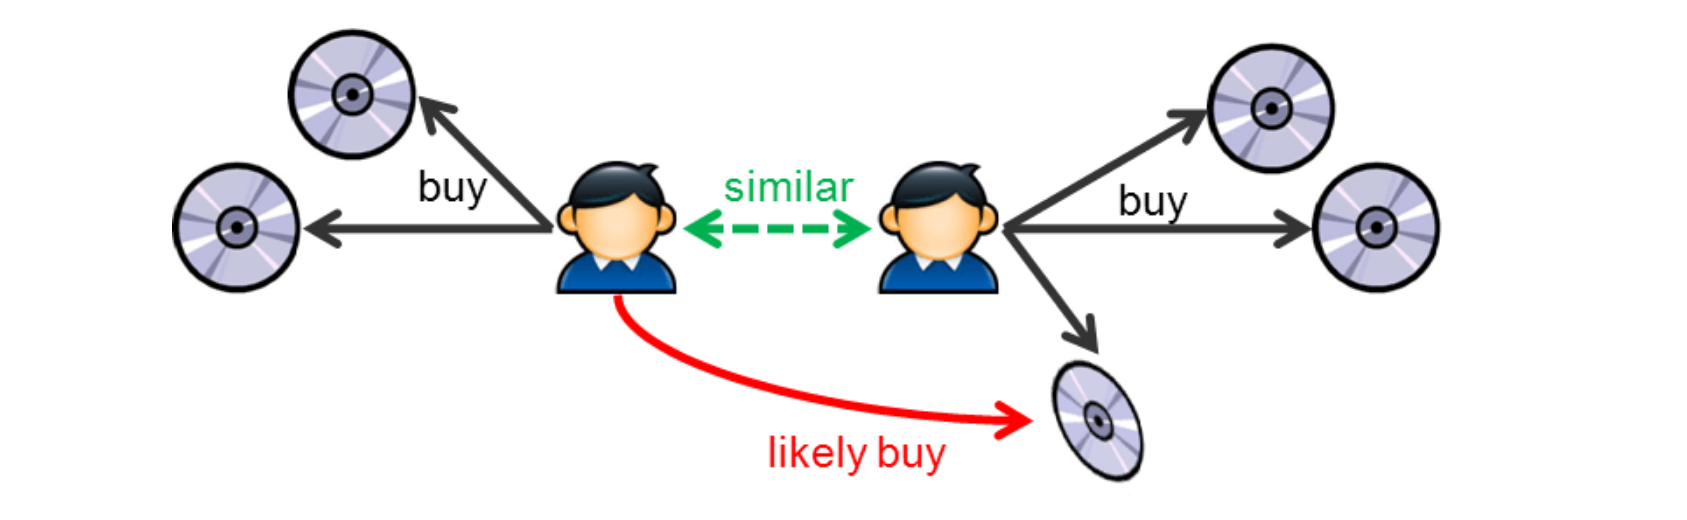

# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import sys

# Exploratory Data Analysis

### Reading File

In [ ]:
#df=pd.read_excel("Online Retail.xlsx")
df=pd.read_csv("Online Retail.csv") #Gives higher Read Speed
df

### Checking Information About Dataset

In [ ]:
df.info()

In [ ]:
df.describe()

### Removing Postage Prices (It is not Related to Customers)

In [ ]:
df[df["StockCode"]=="POST"]

In [ ]:
df = df[~df['StockCode'].str.contains('POST', na=False)]
df

# Data Augumentation

### Removing Null Data

In [ ]:
df = df.dropna(subset=['CustomerID']) 
df

### Converting to Required DataType

In [ ]:
df_clean = df.copy()
df_clean.loc[:, 'InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean.loc[:, 'CustomerID'] = df_clean['CustomerID'].astype(int)
df = df_clean.copy()
df

### Checking Null Values

In [ ]:
df.isna().sum()

### Removing Non-Useful Data

In [ ]:
df=df[(df['UnitPrice']>0) & (df['Quantity']>0)]
df

### Checking New Info

In [ ]:
df.info()

### Checking No. of Cancelled Orders

In [ ]:
df["InvoiceNo"].apply(str).str.startswith("C").sum()

### Checking Outliers

In [ ]:
def check_outliers(dataframe, variable, ax):
    sns.boxplot(dataframe[variable],color='skyblue', ax=ax)
    ax.set_title('Boxplot of '+variable)
    ax.set_xlabel(variable)

columns = ['UnitPrice', 'Quantity']
fig, axs = plt.subplots(1, len(columns), figsize=(10, 5))

for i, col in enumerate(columns):
    check_outliers(df, col, axs[i])

plt.tight_layout()
plt.show()

### Removing Outliers

In [ ]:
def remove_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
    return outliers

outliers = remove_outliers(df['UnitPrice'])
df=df[~outliers]

# Data Visualisation

### Bar Plot of Frequency of Customers over Country

In [ ]:
df['Country'].value_counts().head(10).plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Bar Plot of Country')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()

##### Inference:-
From this bar plot, we can infer the following:-
1. United Kingdom has the highest frequency: The United Kingdom appears over 300,000 times, making it the most frequent country compared to others.

2. Other countries have lower frequencies: Germany has the second-highest frequency, but it’s around 10,000 times, significantly lower than the United Kingdom.

### Scatter Plot of Quantity over UnitPrice

In [ ]:
plt.scatter(df['Quantity'], df['UnitPrice'], color='skyblue', edgecolor='black', alpha=0.5)
plt.title('Scatter Plot of Quantity vs UnitPrice')
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')

# Logarithmic Scale: Both axes are in logarithmic scale. This is done to visualize skewed distribution.
plt.xscale('log')
plt.yscale('log')
plt.show()

##### Inference:-
1. Outliers: There is 1 outliers on the lower left and 2 on upper right of the plot.

2. These represent transactions with Very Low Unit Price,Very Low Quantity & Very High Quantity.

### Time Series Plot of Quantity over InvoiceDate

In [ ]:
df.set_index('InvoiceDate')['Quantity'].plot(color='skyblue')
plt.title('Time Series Plot of Quantity over InvoiceDate')
plt.xlabel('InvoiceDate')
plt.ylabel('Quantity')
plt.show()

##### Inference:-
1. Consistent Sales: Most of the time, the quantity of items sold is relatively low and consistent. This suggests a steady demand for the products.

2. Sales Spikes: There are two large spikes in quantity sold, one in Jan-Feb 2011 and one after November 2011. These could be due to increased demand, promotional events, or other factors that increased sales during these periods.

## Cleaned DataSet

In [ ]:
df

# Collaborative Filtering

### Aggregating Purchase Quantities

In [ ]:
# Sum 'Quantity' for each 'CustomerID' and 'StockCode' pair
df_agg = df.groupby(['CustomerID', 'StockCode'])['Quantity'].sum().reset_index()
df_agg

### Creating Pivot Table

In [ ]:
# Create a pivot table with users as rows and items as columns
pivot_table = df_agg.pivot(index='CustomerID', columns='StockCode', values='Quantity').fillna(0)
pivot_table

### Conversion to Sparse Matrix

In [ ]:
# Convert the pivot table to a sparse matrix
matrix = csr_matrix(pivot_table.values)
matrix

### K Nearest Neighbour - Cosine Similarity

In [ ]:
# Fit the KNN model to data
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(matrix)

# Recommend Function

In [ ]:
def recommend_items(user_id, date, n_recommendations=5):
    # Input validation
    if not isinstance(n_recommendations, int) or n_recommendations <= 0:
        print("n_recommendations must be a positive integer.")
        return
    
    # Handle missing values
    if pivot_table.isnull().any().any() or df.isnull().any().any():
        print("Data contains missing values.")
        return
    
    # Check if user_id exists in the data else return
    if user_id not in pivot_table.index:
        print(f"User ID {user_id} does not exist in the data.")
        return
    
    # Check if date is within range else return
    min_date=df['InvoiceDate'].min().date()
    max_date=df['InvoiceDate'].max().date()
    
    if not min_date <= date <= max_date:
        min_date = min_date.strftime("%d-%m-%Y")
        max_date = max_date.strftime("%d-%m-%Y")
        print(f"Date is out of range. Please choose a date between {min_date} and {max_date}.")
        return
    
    try:
        # Get the top n similar users for a given user
        distances,indices=model_knn.kneighbors(pivot_table.loc[user_id].values.reshape(1,-1),n_neighbors=n_recommendations+1)
        
        recommended_items = []
        
        # Get recommendations from similar users
        for i in range(1, len(distances.flatten())):
            similar_user_id = pivot_table.index[indices.flatten()[i]]
            purchases_by_similar_user = df[(df['CustomerID'] == similar_user_id) & (df['InvoiceDate'].dt.date == date)]
            
            # If no purchases on the given date, get the most popular items purchased by the similar user
            if purchases_by_similar_user.empty:
                purchases_by_similar_user = df[df['CustomerID'] == similar_user_id]
            
            for _, row in purchases_by_similar_user.iterrows():
                item = (row['StockCode'], row['Description'])
                if item not in recommended_items:
                    recommended_items.append(item)
                    
        if not recommended_items:
            print("No recommendations found.")
            return
        
        return recommended_items[:n_recommendations]
    
    except Exception as e:
        print(f"An error occurred: {e}")

# Testing the Function

In [ ]:
#Some most frequent customers:- 17841, 14911, 14096, 12748, 14606, 15311, 14646, 13089, 13263, 14298
#Some least frequent customers:- 14795, 13366, 18084, 13120, 17443, 15562, 15216, 17382, 15389, 16073
#Enter CustomerID Here
#cid=16072
# Enter CustomerID Here
verifycid=0
cid_input = input("Enter CustomerID")
if not cid_input.isnumeric():
    print("Invalid Customer ID. Please enter a 5 digit number.")
    exit
else:
    cid = int(cid_input)
    verifycid=1

try:
    # Enter Date Here (Choose a date between 01-12-2010 and 09-12-2011)
    #date_string = "01-10-2011"
    date_string=input("Enter Date in dd-mm-yyyy Format")
    # Extract date
    date_object = datetime.strptime(date_string, "%d-%m-%Y").date()
    
    if verifycid:
        output = recommend_items(cid,date_object)
        if output:
            for i, item in enumerate(output, start=1):
                print(f"{i}):")
                print(f"Stock Code: {item[0]}")
                print(f"Description: {item[1]}\n")
            
except ValueError:
    print("Invalid date format. Please enter the date in 'dd-mm-yyyy' format.")